<a href="https://colab.research.google.com/github/AbiemwenseMaureenOshobugie/Machine-Learning-in-Finance/blob/main/Deep_Learning_in_Finance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Short-Term Market Trends with Deep Learning



# **1. Introduction:**

This project involves experimenting with RNN models to predict short-term market trends across different asset classes. From exploratory data analysis, we move to training and testing LSTM single-output and multi-output models, which are further backtested for reasons of robustness checks.

## **Libraries**

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import scipy.stats as stats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import yfinance as yf
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

# Ensuring reproducibility
tf.config.experimental.enable_op_determinism()
import os, random
random.seed(1234)
np.random.seed(1234)
tf.random.set_seed(1234)
os.environ['PYTHONHASHSEED'] = str(1234)
#session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
#sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
#tf.compat.v1.keras.backend.set_session(sess)

import warnings
warnings.filterwarnings('ignore')

# **2. Project Details:**

## Step 1

### **Data gathering**

In [ ]:
# Select 5 ETFs
ETF_T = 'SPY' # equity
FI_T = 'TLT' # fixed income
TRE_T = 'SHY' # 1-3 treasury bonds
GLD_T = 'GLD' # gold
CRD_T ='DBO' # crude oil

# Download historical data for the 5 ETFs, from Jan 01 2008 to Dec 12 2017
ETF_D = yf.download(ETF_T, start='2008-01-01', end='2017-12-31')  # Get data for the past 10 years - period='10y'
FI_D = yf.download(FI_T, start='2008-01-01', end='2017-12-31')  # Get data for the past 10 years - period='10y'
TRE_D = yf.download(TRE_T, start='2008-01-01', end='2017-12-31')  # Get data for the past 10 years - period='10y'
GLD_D = yf.download(GLD_T, start='2008-01-01', end='2017-12-31')  # Get data for the past 10 years - period='10y'
CRD_D = yf.download(CRD_T, start='2008-01-01', end='2017-12-31')  # Get data for the past 10 years - period='10y'

# Keep daily adjusted close prices
ETF_D = ETF_D[['Adj Close', 'Volume']].dropna()
FI_D = FI_D[['Adj Close', 'Volume']].dropna()
TRE_D = TRE_D[['Adj Close', 'Volume']].dropna()
GLD_D = GLD_D[['Adj Close', 'Volume']].dropna()
CRD_D = CRD_D[['Adj Close', 'Volume']].dropna()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [ ]:
# Organize prices in a data frame:

ticker_list = [ETF_T, FI_T, TRE_T, GLD_T, CRD_T]
data_list = [ETF_D, FI_D, TRE_D, GLD_D, CRD_D]

#for T in data_list:
#    print(T.head(),"\n")

df_price = pd.DataFrame()

for i in range(len(ticker_list)):
  df_price[ticker_list[i]] = data_list[i][['Adj Close']]

# reset index
df_price.reset_index(inplace=True)
df_price.head()

,Date,SPY,TLT,SHY,GLD,DBO
0,2008-01-02,105.673462,58.468147,65.783112,84.860001,32.756657
1,2008-01-03,105.622421,58.387581,65.886917,85.570000,32.784111
2,2008-01-04,103.034012,58.400009,65.982841,85.129997,32.445560
3,2008-01-07,102.946526,58.653999,65.942924,84.769997,31.658669
4,2008-01-08,101.284065,58.585812,66.038795,86.779999,31.850822


In [ ]:
# Produce returns from prices:

for i in range(len(ticker_list)):
  df_price[ticker_list[i]+"_Ret"] = df_price[df_price.columns[i+1]].pct_change()

# Convert the 'Date' column to a date-time format
df_price['Date'] = pd.to_datetime(df_price['Date'])
#df.set_index('Date', inplace=True)

df_price.head()

,Date,SPY,TLT,SHY,GLD,DBO,SPY_Ret,TLT_Ret,SHY_Ret,GLD_Ret,DBO_Ret
0,2008-01-02,105.673462,58.468147,65.783112,84.860001,32.756657,NaN,NaN,NaN,NaN,NaN
1,2008-01-03,105.622421,58.387581,65.886917,85.570000,32.784111,-0.000483,-0.001378,0.001578,0.008367,0.000838
2,2008-01-04,103.034012,58.400009,65.982841,85.129997,32.445560,-0.024506,0.000213,0.001456,-0.005142,-0.010327
3,2008-01-07,102.946526,58.653999,65.942924,84.769997,31.658669,-0.000849,0.004349,-0.000605,-0.004229,-0.024253
4,2008-01-08,101.284065,58.585812,66.038795,86.779999,31.850822,-0.016149,-0.001163,0.001454,0.023711,0.006070


### **Exploratory Data Analysis (EDA)**

In [ ]:
#!pip install ydata_profiling
#from ydata_profiling import ProfileReport --quiet
#eda = ProfileReport(df_price)
#display(eda)

In [ ]:
# Descriptive Statistics
overview = df_price.loc[:, df_price.columns != 'Date'].describe().round(4)
overview

,SPY,TLT,SHY,GLD,DBO,SPY_Ret,TLT_Ret,SHY_Ret,GLD_Ret,DBO_Ret
count,2518.0000,2518.0000,2518.0000,2518.0000,2518.0000,2517.0000,2517.0000,2517.0000,2517.0000,2517.0000
mean,133.1250,83.6689,72.4410,122.4630,20.8382,0.0004,0.0003,0.0001,0.0002,-0.0003
std,47.0909,16.9190,2.1465,23.7805,8.9845,0.0128,0.0096,0.0008,0.0121,0.0197
min,50.8567,56.0915,65.7831,70.0000,6.2573,-0.0984,-0.0504,-0.0066,-0.0878,-0.0951
25%,94.2475,66.6706,71.5434,108.8375,12.1258,-0.0039,-0.0056,-0.0004,-0.0055,-0.0103
50%,118.2742,85.8478,73.0684,120.0300,23.5154,0.0006,0.0007,0.0000,0.0004,0.0004
75%,174.8053,98.3862,74.0025,133.7350,25.7837,0.0055,0.0060,0.0004,0.0063,0.0100
max,241.0279,117.8546,75.1577,184.5900,50.3336,0.1452,0.0517,0.0071,0.1129,0.0917


Prices (columns ‘SPY’, ‘TLT’, ‘SHY’, ‘GLD’ and ‘DBO’) follow different patterns, with equity (‘SPY’) exhibiting the greatest average level (mean: 133.13) and range (maximum - minimum: 241.03 - 50.86 = 190.17), cash (‘SHY’) showing the lowest variation (standard deviation: 2.15), crude oil having the lowest average level (mean: 6.26), and fixed income (’TLT’) and cash ranging in the middle (means: 83.67 and 72.44 respectively).

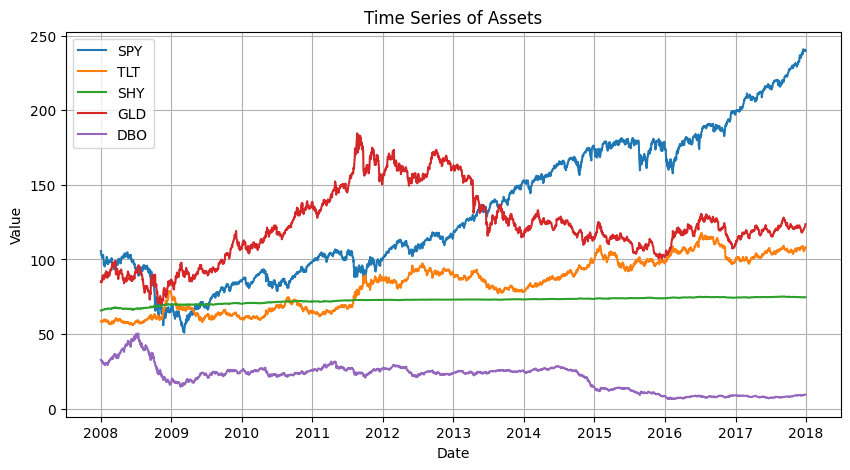

In [ ]:
# Time Series Plot - Prices
plt.figure(figsize=(10, 5))
for column in df_price.columns[1:6]:
    plt.plot(df_price['Date'], df_price[column], label=column)
plt.title('Time Series of Assets')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

SHY exhibits the least fluctuation, as previously noted. DBO is fairly stable with decrease in average levels before 2009 and 2015, alluding to the global financial crisis of 2008 and the supply-driven oil plunge in 2014-2016. TLT has a mild overall growth trend (between 50 and 120). From 2009 to 2018, SPY grows five-fold, while GLD has a peak in 2011-2013.

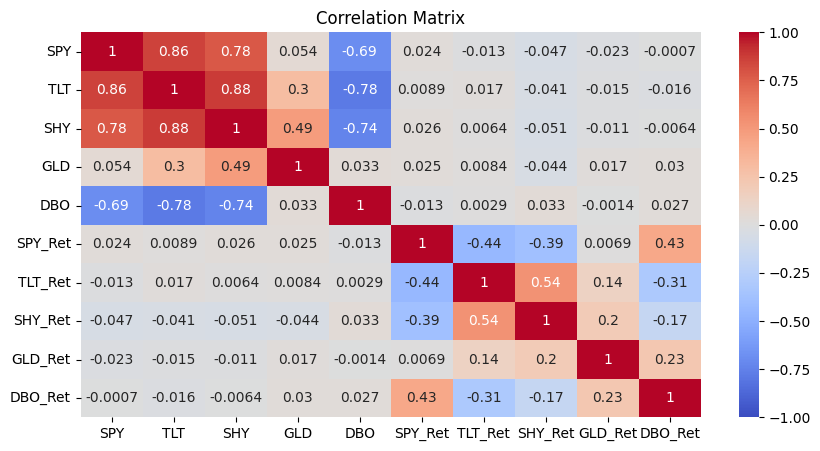

In [ ]:
# Correlation Heatmap - Prices
corr_matrix = round(df_price[df_price.columns[1:]].corr(),4)
plt.figure(figsize=(10, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

Prices are generally highly correlated to each other (SPY, TLT and SHY positively between them and negatively with DBO), with GLD only being moderately correlated with SHY.Returns are generally little correlated, with moderate correlations between SPY and DBO, SHY and TLT, SPY and TLT (negative), SPY and SHY (negative). This is corroborated by the joint distribution histograms. Calculated returns (‘_Ret’ suffix) have bell-shaped distributions with higher than normal peaks; of them, TLT returns are closest to normally distributed.


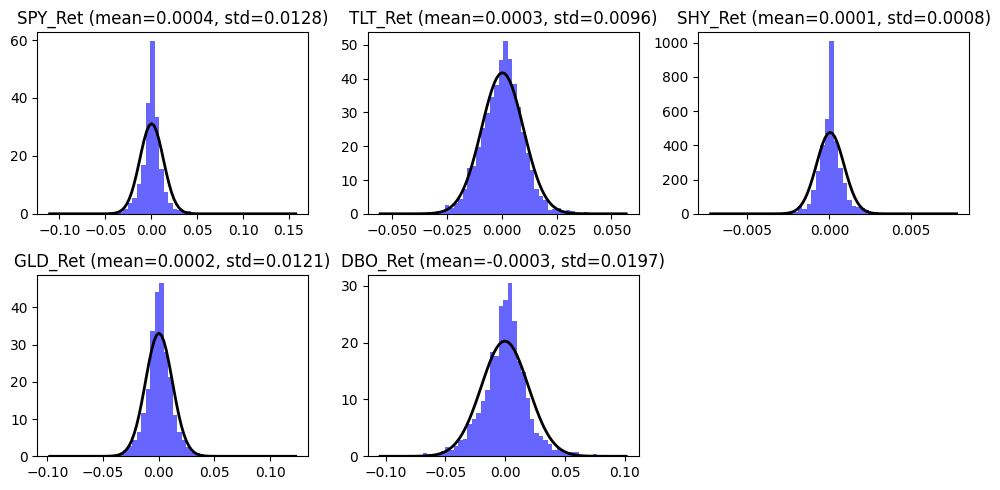

In [ ]:
# Histogram Plots with Normal Distribution curves  - Returns

# List of return columns to plot
return_columns = ['SPY_Ret', 'TLT_Ret', 'SHY_Ret', 'GLD_Ret', 'DBO_Ret']
# Number of columns to plot
n_tickers = len(return_columns)

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 5))

# Plot each histogram with a normal distribution curve
for i in range(n_tickers):
    data = df_price[return_columns[i]] # ~ df_price.iloc[:, 6+i:]

    # Calculate mean and standard deviation
    mu = np.mean(data)
    sigma = np.std(data)

    # Determine the correct subplot using divmod
    row = i // 3  # Use // for integer division to determine the row
    col = i % 3   # Use % to get the remainder, which determines the column

    # Plot histogram
    axes[row, col].hist(data, bins=50, density=True, alpha=0.6, color='b')  # density=True normalizes the histogram

    # Generate points on the x-axis
    xmin, xmax = axes[row, col].get_xlim()
    x = np.linspace(xmin, xmax, 100)

    # Plot normal distribution curve
    p = stats.norm.pdf(x, mu, sigma)
    axes[row, col].plot(x, p, 'k', linewidth=2)

    # Set title
    axes[row, col].set_title(f'{return_columns[i]} (mean={mu:.4f}, std={sigma:.4f})') # fontsize = 40

# Adjust layout and display
plt.tight_layout()
axes[1, 2].axis('off')
plt.show()

<Figure size 1000x1000 with 0 Axes>

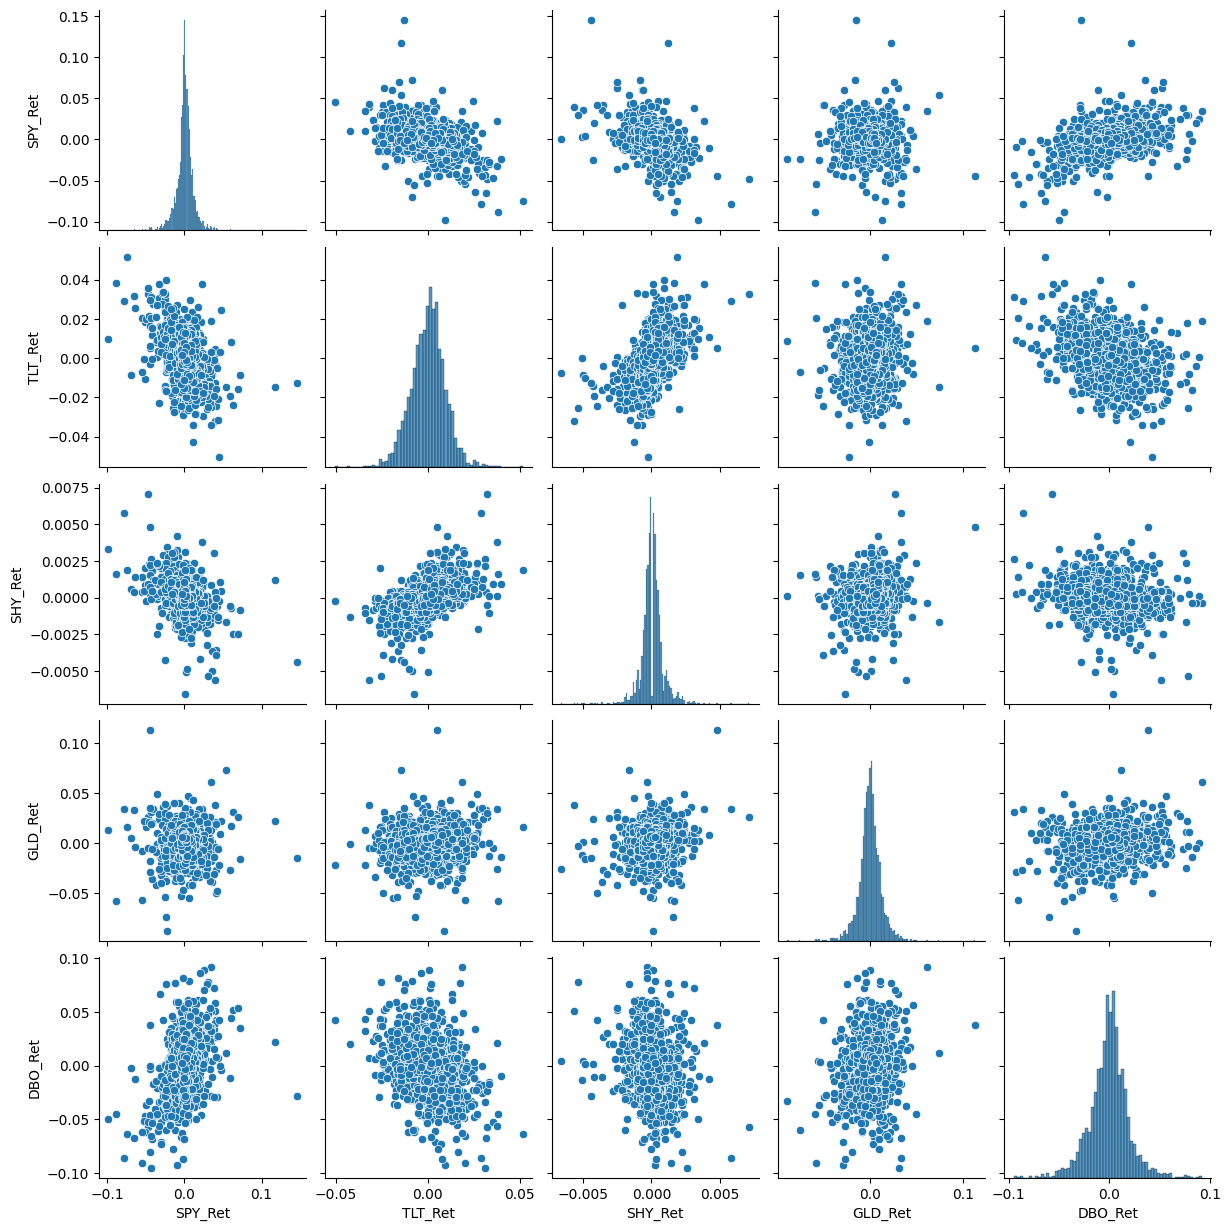

In [ ]:
# Joint Distribution Plots  - Returns
plt.figure(figsize=(10, 10))
sns.pairplot(df_price[df_price.columns[6:]])
plt.show()

### **Seasonality and Stationarity analysis**

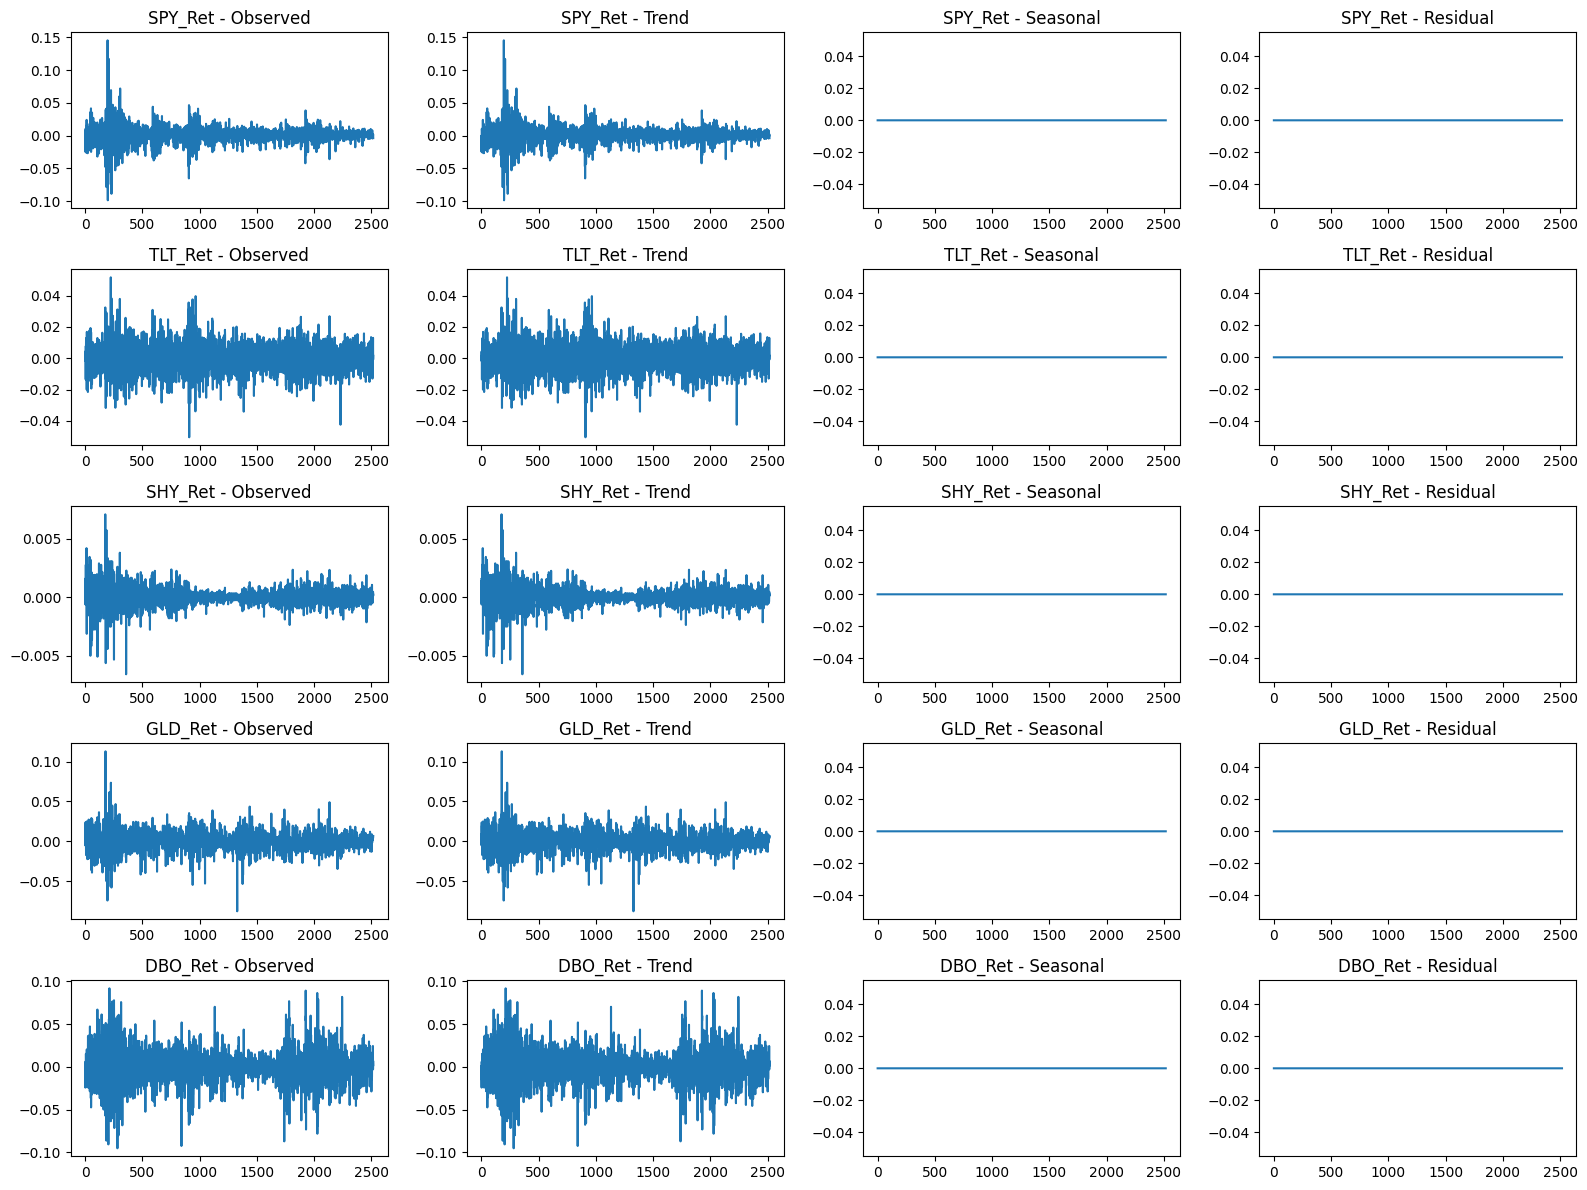

In [ ]:
# Function to check stationarity using the Augmented Dickey-Fuller test
def check_stationarity(series):
    result = adfuller(series.dropna())
    return {
        'ADF Statistic': result[0],
        'p-value': result[1],
        'Critical Values': result[4]
    }

# Visualize seasonality and stationarity for each return column
seasonal_plots = {}
stationarity_results = {}

# Loop over the last 5 data columns which are the return columns
for column in df_price.columns[-5:]:
    # Decompose the time series
    decomposition = seasonal_decompose(df_price[column].dropna(), model='additive', period=1)
    seasonal_plots[column] = decomposition

    # Check stationarity
    stationarity_results[column] = check_stationarity(df_price[column])

# Plot the decompositions for each asset's returns
plt.figure(figsize=(16, 12))
for i, column in enumerate(df_price.columns[-5:], 1):  # Start at 1 for subplot indexing
    plt.subplot(5, 4, i*4-3)
    plt.plot(seasonal_plots[column].observed)
    plt.title(f'{column} - Observed')

    plt.subplot(5, 4, i*4-2)
    plt.plot(seasonal_plots[column].trend)
    plt.title(f'{column} - Trend')

    plt.subplot(5, 4, i*4-1)
    plt.plot(seasonal_plots[column].seasonal)
    plt.title(f'{column} - Seasonal')

    plt.subplot(5, 4, i*4)
    plt.plot(seasonal_plots[column].resid)
    plt.title(f'{column} - Residual')

plt.tight_layout()
plt.show()

In [ ]:
# Show ADF test statistics

df = pd.DataFrame(stationarity_results)

# Flatten the 'Critical Values' column
critical_values = df.loc['Critical Values'].apply(pd.Series)
df = df.drop('Critical Values').transpose()
# Coerce everything to numeric (helps with rounding)
df = df.apply(pd.to_numeric, errors='coerce')

# Display the resulting DataFrame
result = pd.concat([df, critical_values], axis=1, join='inner').round(4)
result

,ADF Statistic,p-value,1%,5%,10%
SPY_Ret,-11.4817,0.0,-3.433,-2.8627,-2.5674
TLT_Ret,-24.4988,0.0,-3.433,-2.8627,-2.5674
SHY_Ret,-9.6338,0.0,-3.433,-2.8627,-2.5674
GLD_Ret,-50.4496,0.0,-3.433,-2.8627,-2.5674
DBO_Ret,-52.3673,0.0,-3.433,-2.8627,-2.5674


Time-series decompositions of returns show the lack of trends and seasonality, despite fluctuations at the beginning of the series. Finally, Augmented Dickey-Fuller tests further show that returns are statistically stationary:

## Step 2

### **Additional data gathering**

In [ ]:
# Re-define the ETF tickers
tickers = ["SPY", "TLT", "SHY", "GLD", "DBO"]

# Define the time periods
train_start = "2008-01-01" # training start
train_end = "2016-12-31" # training end
val_start = "2017-02-01" # validation start
val_end = "2017-11-30" # validation end
test_start = "2018-01-01" # test start
test_end = "2022-12-30" # test end

# Download data for each period #and calculate returns
train_data = yf.download(tickers, start=train_start, end=train_end)['Adj Close']#.pct_change()[1:]
val_data = yf.download(tickers, start=val_start, end=val_end)['Adj Close']#.pct_change()[1:]
test_data = yf.download(tickers, start=test_start, end=test_end)['Adj Close']#.pct_change()[1:]

[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  5 of 5 completed


### **Data preparation**

In [ ]:
# Create individual DataFrames for each asset class
df_dates =  {'train' : train_data.index, 'val' : val_data.index, 'test' : test_data.index}

df_asset_1 = { 'train': train_data['SPY'], 'val': val_data['SPY'], 'test': test_data['SPY']}
df_asset_2 = { 'train': train_data['TLT'], 'val': val_data['TLT'], 'test': test_data['TLT']}
df_asset_3 = { 'train': train_data['SHY'], 'val': val_data['SHY'], 'test': test_data['SHY']}
df_asset_4 = { 'train': train_data['GLD'], 'val': val_data['GLD'], 'test': test_data['GLD']}
df_asset_5 = { 'train': train_data['DBO'], 'val': val_data['DBO'], 'test': test_data['DBO']}

In [ ]:
# Create helpful functions

def scale_data(train_data, test_data):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    train_scaled = scaler.fit_transform(train_data)
    test_scaled = scaler.transform(test_data)
    return train_scaled, test_scaled, scaler

def create_sequences(data, dates, sequence_length):
    X, y, y_dates = [], [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])  # Target value
        y_dates.append(dates[i + sequence_length])  # Date corresponding to the target value
    return np.array(X), np.array(y), np.array(y_dates)

def prepare_data(df_asset, df_dates, sequence_length):
    # Extracting data for scaling
    train_data = df_asset['train'].values.reshape(-1, 1)
    val_data = df_asset['val'].values.reshape(-1, 1)
    test_data = df_asset['test'].values.reshape(-1, 1)

    # Scaling the data and obtaining the scaler
    train_scaled, val_scaled, scaler = scale_data(train_data, val_data)
    test_scaled = scaler.transform(test_data)

    # Extract dates
    dates_train = df_dates['train']
    dates_val = df_dates['val']
    dates_test = df_dates['test']

    # Create sequences
    X_train_seq, y_train_seq, dates_y_train = create_sequences(train_scaled, dates_train, sequence_length)
    X_val_seq, y_val_seq, dates_y_val = create_sequences(val_scaled, dates_val, sequence_length)
    X_test_seq, y_test_seq, dates_y_test = create_sequences(test_scaled, dates_test, sequence_length)

    return X_train_seq, y_train_seq, X_val_seq, y_val_seq, X_test_seq, y_test_seq, dates_y_test, dates_y_train, scaler

In [ ]:
# Apply to each asset
sequence_length = 25  # Define the sequence length for the input
results_1 = prepare_data(df_asset_1, df_dates, sequence_length)
results_2 = prepare_data(df_asset_2, df_dates, sequence_length)
results_3 = prepare_data(df_asset_3, df_dates, sequence_length)
results_4 = prepare_data(df_asset_4, df_dates, sequence_length)
results_5 = prepare_data(df_asset_5, df_dates, sequence_length)

# Unpacking results
(X_train_seq_1, y_train_seq_1, X_val_seq_1, y_val_seq_1, X_test_seq_1, y_test_seq_1, dates_y_test_1, dates_y_train_1, scaler_1) = results_1 # scaler_1
(X_train_seq_2, y_train_seq_2, X_val_seq_2, y_val_seq_2, X_test_seq_2, y_test_seq_2, dates_y_test_2, dates_y_train_2, scaler_2) = results_2
(X_train_seq_3, y_train_seq_3, X_val_seq_3, y_val_seq_3, X_test_seq_3, y_test_seq_3, dates_y_test_3, dates_y_train_3, scaler_3) = results_3
(X_train_seq_4, y_train_seq_4, X_val_seq_4, y_val_seq_4, X_test_seq_4, y_test_seq_4, dates_y_test_4, dates_y_train_4, scaler_4) = results_4
(X_train_seq_5, y_train_seq_5, X_val_seq_5, y_val_seq_5, X_test_seq_5, y_test_seq_5, dates_y_test_5, dates_y_train_5, scaler_5) = results_5

In [ ]:
# Output Information

# Initialize an empty list to store the data
data_s = []

# Loop through each result and collect information
for i, (X_train_seq, y_train_seq, X_val_seq, y_val_seq,
        X_test_seq, y_test_seq, dates_y_test, dates_y_train, scaler) in enumerate(
    [results_1, results_2, results_3, results_4, results_5], start=1):

    # Append the data for each asset to the list
    data_s.append({
        'Asset': f'Asset {i}',
        'X_train_seq_shape': X_train_seq.shape,
        'y_train_seq_shape': y_train_seq.shape,
        'X_val_seq_shape': X_val_seq.shape,
        'y_val_seq_shape': y_val_seq.shape,a
        'X_test_seq_shape': X_test_seq.shape,
        'y_test_seq_shape': y_test_seq.shape,
        'Dates_y_test_length': len(dates_y_test),
        'Scaler_min_': scaler.min_[0],
        'Scaler_scale_': scaler.scale_[0]
    })

# Create a DataFrame from the collected data
df_info = pd.DataFrame(data_s).set_index('Asset').round(4)
df_info.T

Asset,Asset 1,Asset 2,Asset 3,Asset 4,Asset 5
X_train_seq_shape,"(2242, 25, 1)","(2242, 25, 1)","(2242, 25, 1)","(2242, 25, 1)","(2242, 25, 1)"
y_train_seq_shape,"(2242, 1)","(2242, 1)","(2242, 1)","(2242, 1)","(2242, 1)"
X_val_seq_shape,"(185, 25, 1)","(185, 25, 1)","(185, 25, 1)","(185, 25, 1)","(185, 25, 1)"
y_val_seq_shape,"(185, 1)","(185, 1)","(185, 1)","(185, 1)","(185, 1)"
X_test_seq_shape,"(1233, 25, 1)","(1233, 25, 1)","(1233, 25, 1)","(1233, 25, 1)","(1233, 25, 1)"
y_test_seq_shape,"(1233, 1)","(1233, 1)","(1233, 1)","(1233, 1)","(1233, 1)"
Dates_y_test_length,1233,1233,1233,1233,1233
Scaler_min_,-1.6838,-2.8163,-15.2828,-2.2217,-1.2839
Scaler_scale_,0.0134,0.0324,0.2171,0.0175,0.0454


### a. Building the Model

In [ ]:
# Define the LSTM model architecture
def build_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=100, return_sequences=True, input_shape=input_shape, kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.2, seed=1234))
    model.add(LSTM(units=50, return_sequences=False, kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.2, seed=1234))
    model.add(Dense(units=1))

    model.compile(optimizer='adam', loss='mse')
    return model

# Define input shape (sequence length, number of features)
input_shape = (sequence_length, 1)

# Build models for each asset
model_1 = build_model(input_shape)
model_2 = build_model(input_shape)
model_3 = build_model(input_shape)
model_4 = build_model(input_shape)
model_5 = build_model(input_shape)

In [ ]:
# See the Architecture of one Model (all are the same)
model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 25, 100)             │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 25, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          30,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 71,051 (277.54 KB)

 Trainable params: 71,051 (277.54 KB)

 Non-trainable params: 0 (0.00 B)

### b. Training the Model

In [ ]:
# Define the train_model function
def train_model(model, X_train, y_train, validation_data=None, epochs=10, batch_size=32):
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    history = model.fit(X_train, y_train, validation_data=validation_data,
                        epochs=epochs, batch_size=batch_size, callbacks=[early_stopping], verbose=0)
    print("model trained")
    return history

# Define the loss plot function
def plot_histories_on_subplots(histories, labels):
    # Create a 2x3 grid of subplots
    fig, axes = plt.subplots(2, 3, figsize=(12, 6))
    axes = axes.flatten()  # Flatten the 2x3 array of axes into a 1D array for easy iteration

    for i, (ax, history, label) in enumerate(zip(axes, histories, labels)):
        ax.plot(history.history['loss'], label=f'Train Loss')
        ax.plot(history.history['val_loss'], label=f'Validation Loss')
        ax.set_title(f'{label} ('+tickers[i]+')') # - Training and Validation Loss
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.legend()
        ax.grid(True)

    # Hide the last subplot if there are fewer than 6 histories
    if len(histories) < len(axes):
        for j in range(len(histories), len(axes)):
            fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Define the prediction function
def generate_predictions(model, X_test):
    predictions = model.predict(X_test, verbose=0)
    return predictions

# Function to plot predictions vs actual values in a grid
def plot_predictions_vs_actual(dates, y_actual, y_pred, asset_number, ax):
    ax.plot(dates, y_actual, label='Actual Values')
    ax.plot(dates, y_pred, label='Predicted Values', linestyle='--')
    ax.set_xlabel('Date')
    ax.set_ylabel('Value')
    ax.set_title(f'Asset {asset_number} ('+tickers[asset_number-1]+')') # : Actual vs Predicted Values
    ax.legend()
    ax.grid(True)
    ax.tick_params(axis='x', rotation=45)

iteration complete
iteration complete
iteration complete
iteration complete
iteration complete


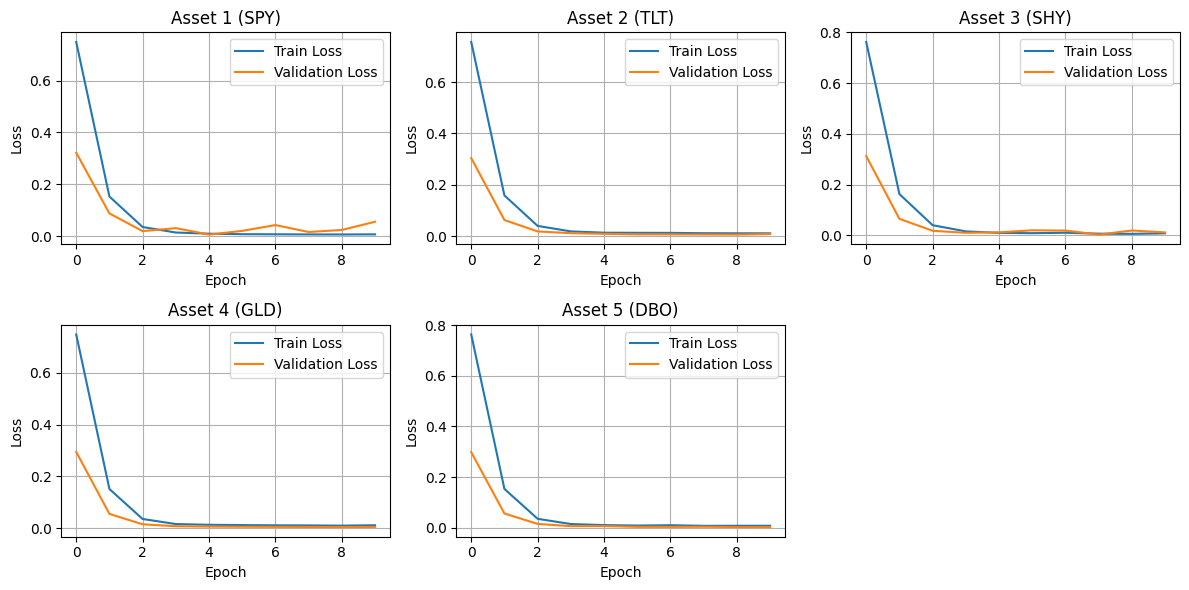

In [ ]:
# Train each model using the train_model function with separate validation data
history_1 = train_model(model_1, X_train_seq_1, y_train_seq_1, validation_data=(X_val_seq_1, y_val_seq_1))
history_2 = train_model(model_2, X_train_seq_2, y_train_seq_2, validation_data=(X_val_seq_2, y_val_seq_2))
history_3 = train_model(model_3, X_train_seq_3, y_train_seq_3, validation_data=(X_val_seq_3, y_val_seq_3))
history_4 = train_model(model_4, X_train_seq_4, y_train_seq_4, validation_data=(X_val_seq_4, y_val_seq_4))
history_5 = train_model(model_5, X_train_seq_5, y_train_seq_5, validation_data=(X_val_seq_5, y_val_seq_5))

# List of training histories and their corresponding labels
histories = [history_1, history_2, history_3, history_4, history_5]
labels = ['Asset 1', 'Asset 2', 'Asset 3', 'Asset 4', 'Asset 5']

# Plot training histories
plot_histories_on_subplots(histories, labels)

In [ ]:
# Generate predictions for each model
predictions_1 = generate_predictions(model_1, X_train_seq_1)
predictions_2 = generate_predictions(model_2, X_train_seq_2)
predictions_3 = generate_predictions(model_3, X_train_seq_3)
predictions_4 = generate_predictions(model_4, X_train_seq_4)
predictions_5 = generate_predictions(model_5, X_train_seq_5)

# Create lists
scalers_list = [scaler_1, scaler_2, scaler_3, scaler_4, scaler_5]
predictions_list = [predictions_1, predictions_2, predictions_3, predictions_4, predictions_5]
y_train_seq_list = [y_train_seq_1, y_train_seq_2, y_train_seq_3, y_train_seq_4, y_train_seq_5]

# Apply inverse transform and flatten predictions
for i in range(len(predictions_list)):
    predictions_list[i] = scalers_list[i].inverse_transform(predictions_list[i].reshape(-1, 1)).flatten()

# Apply inverse transform and flatten y_test
for i in range(len(y_train_seq_list)):
    y_train_seq_list[i] = scalers_list[i].inverse_transform(y_train_seq_list[i].reshape(-1, 1)).flatten()

# Calculate R-squared and MSE for each asset to evaluate out-of-sample-performance
for i, (y_true, y_pred) in enumerate(zip(y_train_seq_list, predictions_list), start=1):
    r2 = r2_score(y_true, y_pred).round(4)
    mse = mean_squared_error(y_true, y_pred).round(4)
    print(f"Asset {i}: In-sample R-squared {r2} and MSE {mse}")


Asset 1: In-sample R-squared 0.9871 and MSE 20.3872
Asset 2: In-sample R-squared 0.9794 and MSE 5.4311
Asset 3: In-sample R-squared 0.9906 and MSE 0.0388
Asset 4: In-sample R-squared 0.931 and MSE 42.7474
Asset 5: In-sample R-squared 0.9722 and MSE 1.9365


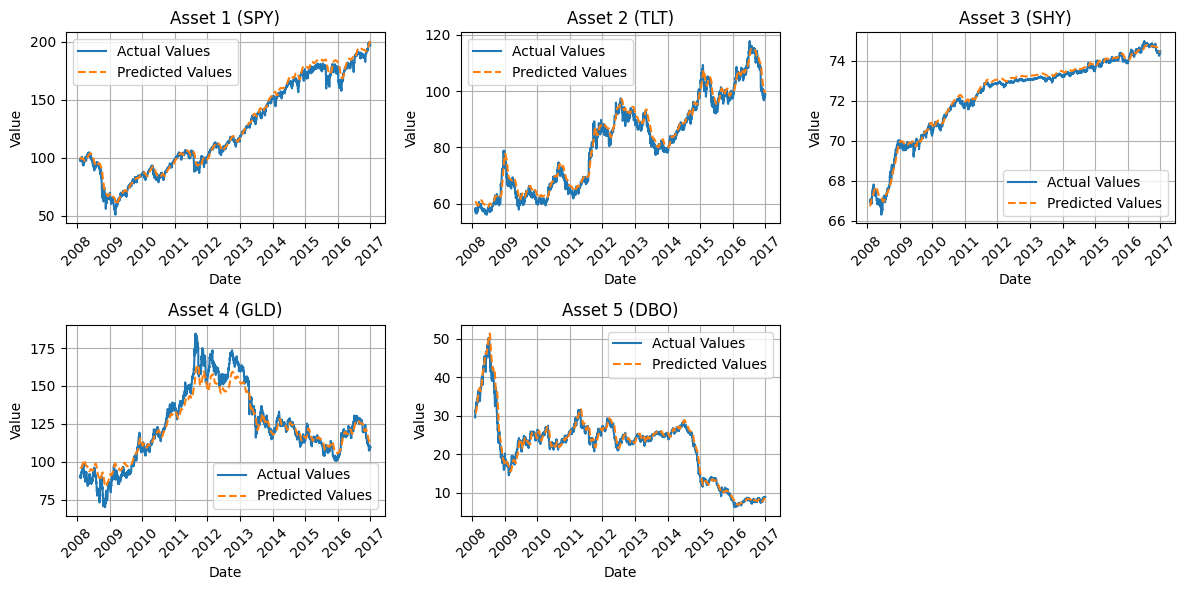

In [ ]:
# Create DataFrames for Predictions and Actual Values - training set
df_predictions_1 = pd.DataFrame({"Date": dates_y_train.flatten(), "Pred LSTM": predictions_list[0], "Actual": y_train_seq_list[0]})
df_predictions_2 = pd.DataFrame({"Date": dates_y_train.flatten(), "Pred LSTM": predictions_list[1], "Actual": y_train_seq_list[1]})
df_predictions_3 = pd.DataFrame({"Date": dates_y_train.flatten(), "Pred LSTM": predictions_list[2], "Actual": y_train_seq_list[2]})
df_predictions_4 = pd.DataFrame({"Date": dates_y_train.flatten(), "Pred LSTM": predictions_list[3], "Actual": y_train_seq_list[3]})
df_predictions_5 = pd.DataFrame({"Date": dates_y_train.flatten(), "Pred LSTM": predictions_list[4], "Actual": y_train_seq_list[4]})

fig, axs = plt.subplots(2, 3, figsize=(12, 6)) # Create a figure with a 2x3 grid of subplots
axs = axs.flatten() # Flatten the array of axes for easier iteration

# Plot for each asset - training set, prices
for i in range(5):
    plot_predictions_vs_actual(dates_y_train.flatten(), y_train_seq_list[i], predictions_list[i], i+1, axs[i])

fig.delaxes(axs[5]) # Turn off the empty subplot (6th subplot)
plt.tight_layout() # Adjust layout
plt.show()

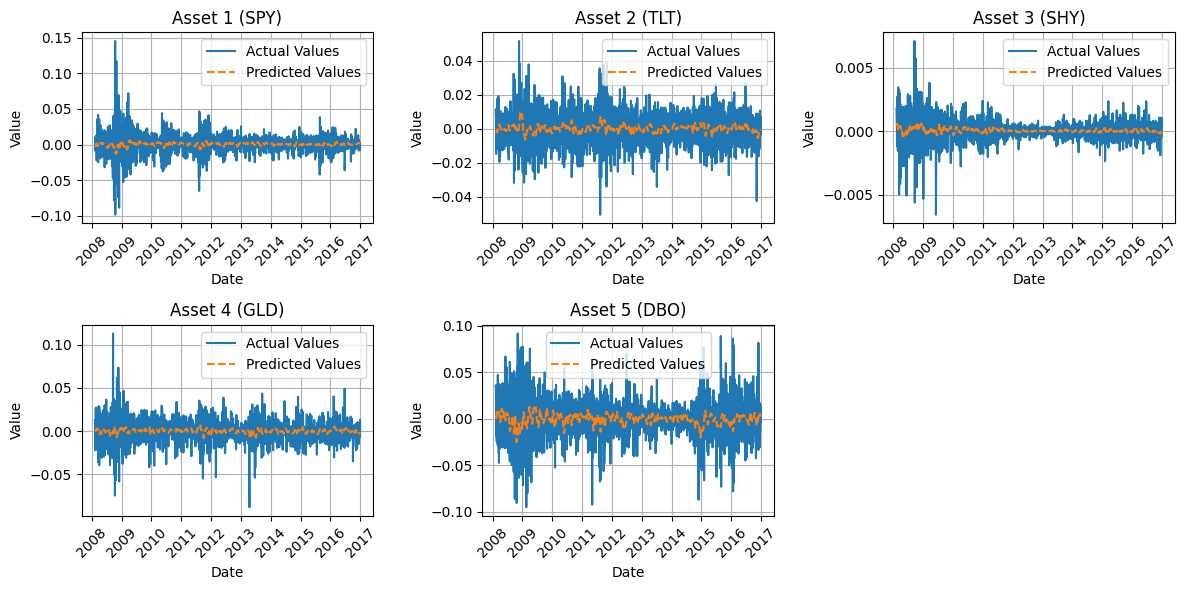

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6)) # Create a figure with a 2x3 grid of subplots
axs = axs.flatten() # Flatten the array of axes for easier iteration

# Plot for each asset - train set, returns
for i in range(5):
    plot_predictions_vs_actual(dates_y_train.flatten()[1:],
                               pd.Series(y_train_seq_list[i]).pct_change()[1:],
                               pd.Series(predictions_list[i]).pct_change()[1:], i+1, axs[i])

fig.delaxes(axs[5]) # Turn off the empty subplot (6th subplot)
plt.tight_layout() # Adjust layout
plt.show()

# Calculate for each asset
for i in range(5):
    y_true = pd.Series(y_train_seq_list[i]).pct_change()[1:]
    y_pred = pd.Series(predictions_list[i]).pct_change()[1:]
    rmse = np.sqrt(mean_squared_error(y_true, y_pred)).round(4)
    print(f"Asset {i+1}: RMSE {rmse}")

In all cases, in-sample performance has been exceptional. For all five asset classes, both training loss and validation loss, as measured by Mean Squared Error (MSE), are below 0.05. Results are stabilized before 10 epochs of training. Overfitting is likely due to high R-squared values. From most accurate to least accurate, models are in order as follows: SHY, DBO, TLT, SPY, GLD. This is evident in the time plots for the fitted training data (please see Jupyter notebook). However, conversion from prices to returns introduces distortions. Actual vs predicted returns are shown in the following graphs; it is evident that our model captures the fluctuating nature but not the magnitude of the time series

### c. Generate Predictions

In [ ]:
# Generate predictions for each model on the test sets
predictions_1 = generate_predictions(model_1, X_test_seq_1)
predictions_2 = generate_predictions(model_2, X_test_seq_2)
predictions_3 = generate_predictions(model_3, X_test_seq_3)
predictions_4 = generate_predictions(model_4, X_test_seq_4)
predictions_5 = generate_predictions(model_5, X_test_seq_5)

# Create lists
scalers_list = [scaler_1, scaler_2, scaler_3, scaler_4, scaler_5]
predictions_list = [predictions_1, predictions_2, predictions_3, predictions_4, predictions_5]
y_test_seq_list = [y_test_seq_1, y_test_seq_2, y_test_seq_3, y_test_seq_4, y_test_seq_5]

# Apply inverse transform and flatten predictions
for i in range(len(predictions_list)):
  predictions_list[i] = scalers_list[i].inverse_transform(predictions_list[i].reshape(-1, 1)).flatten()

# Apply inverse transform and flatten y_test
for i in range(len(y_test_seq_list)):
  y_test_seq_list[i] = scalers_list[i].inverse_transform(y_test_seq_list[i].reshape(-1, 1)).flatten()

# Calculate R-squared for each asset to evaluate out-of-sample-performance
for i, (y_true, y_pred) in enumerate(zip(y_test_seq_list, predictions_list), start=1):
    r2 = r2_score(y_true, y_pred).round(4)
    mse = mean_squared_error(y_true, y_pred).round(4)
    print(f"Asset {i}: Out-of-sample R-squared {r2} and MSE {mse}")

Asset 1: Out-of-sample R-squared -0.4199 and MSE 6863.9524
Asset 2: Out-of-sample R-squared 0.9067 and MSE 27.8049
Asset 3: Out-of-sample R-squared 0.2413 and MSE 3.7692
Asset 4: Out-of-sample R-squared 0.8002 and MSE 100.6342
Asset 5: Out-of-sample R-squared 0.9566 and MSE 0.4499


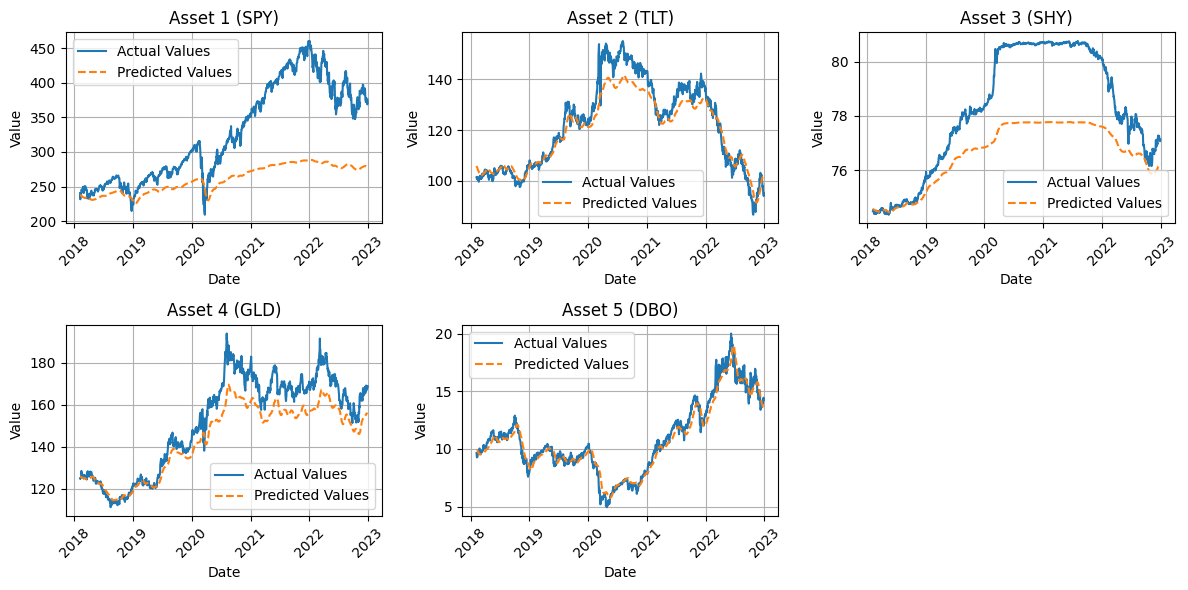

In [ ]:
# Create DataFrames for Predictions and Actual Values
df_predictions_1 = pd.DataFrame({"Date": dates_y_test.flatten(), "Pred LSTM": predictions_list[0], "Actual": y_test_seq_list[0]})
df_predictions_2 = pd.DataFrame({"Date": dates_y_test.flatten(), "Pred LSTM": predictions_list[1], "Actual": y_test_seq_list[1]})
df_predictions_3 = pd.DataFrame({"Date": dates_y_test.flatten(), "Pred LSTM": predictions_list[2], "Actual": y_test_seq_list[2]})
df_predictions_4 = pd.DataFrame({"Date": dates_y_test.flatten(), "Pred LSTM": predictions_list[3], "Actual": y_test_seq_list[3]})
df_predictions_5 = pd.DataFrame({"Date": dates_y_test.flatten(), "Pred LSTM": predictions_list[4], "Actual": y_test_seq_list[4]})

# Create a figure with a 2x3 grid of subplots
fig, axs = plt.subplots(2, 3, figsize=(12, 6))

# Flatten the array of axes for easier iteration
axs = axs.flatten()

# Plot for each asset
for i in range(5):
    plot_predictions_vs_actual(dates_y_test.flatten(), y_test_seq_list[i], predictions_list[i], i+1, axs[i])

fig.delaxes(axs[5]) # Turn off the empty subplot (6th subplot)
plt.tight_layout() # Adjust layout
plt.show()

In most cases, out-of-sample performance is quite high as well. The worst result is given for SPY, where the model, albeit able to detect major troughs and trends, fails to capture finer fluctuations and magnitudes of change. A similar picture is given for SHY (where the low MSE must be seen in conjunction with the low price levels). DBO is perhaps the best modeled asset. This inaccuracy is propagated to estimated returns:

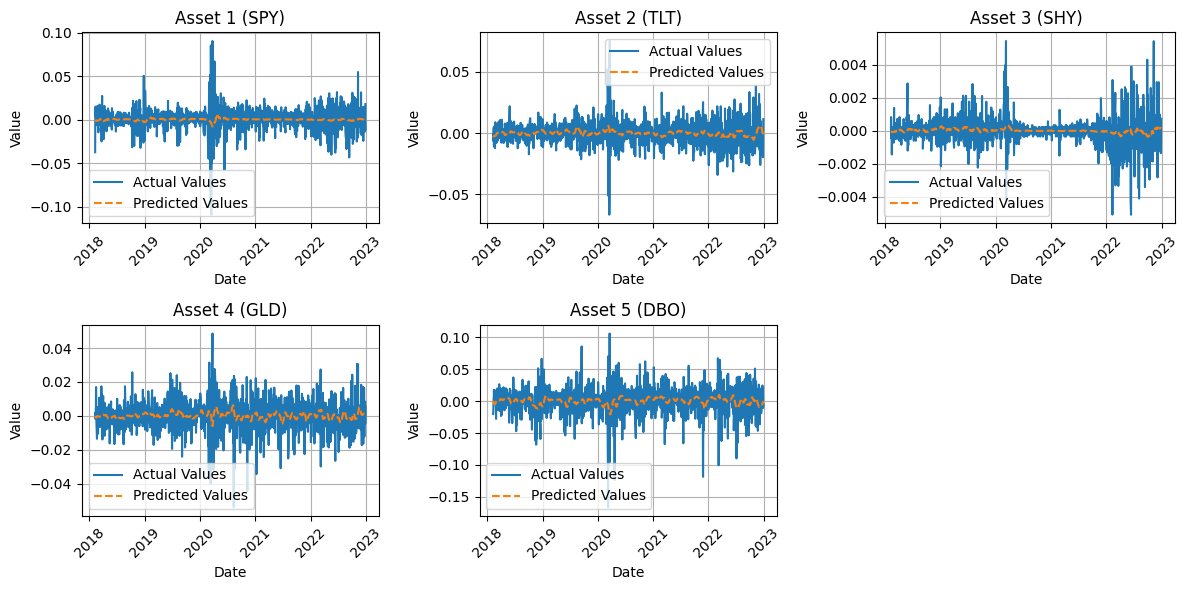

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6)) # Create a figure with a 2x3 grid of subplots
axs = axs.flatten() # Flatten the array of axes for easier iteration

# Plot for each asset
for i in range(5):
    plot_predictions_vs_actual(dates_y_test.flatten()[1:],
                               pd.Series(y_test_seq_list[i]).pct_change()[1:],
                               pd.Series(predictions_list[i]).pct_change()[1:], i+1, axs[i])

fig.delaxes(axs[5]) # Turn off the empty subplot (6th subplot)
plt.tight_layout() # Adjust layout
plt.show()

# Calculate for each asset
for i in range(5):
    y_true = pd.Series(y_test_seq_list[i]).pct_change()[1:]
    y_pred = pd.Series(predictions_list[i]).pct_change()[1:]
    rmse = np.sqrt(mean_squared_error(y_true, y_pred)).round(4)
    print(f"Asset {i+1}: RMSE {rmse}")

### d. Definition of Strategies

We will trade long (buy) all assets whenever the 25-day return predictions are positive and short (sell) assets when negative.

### e. Backtesting


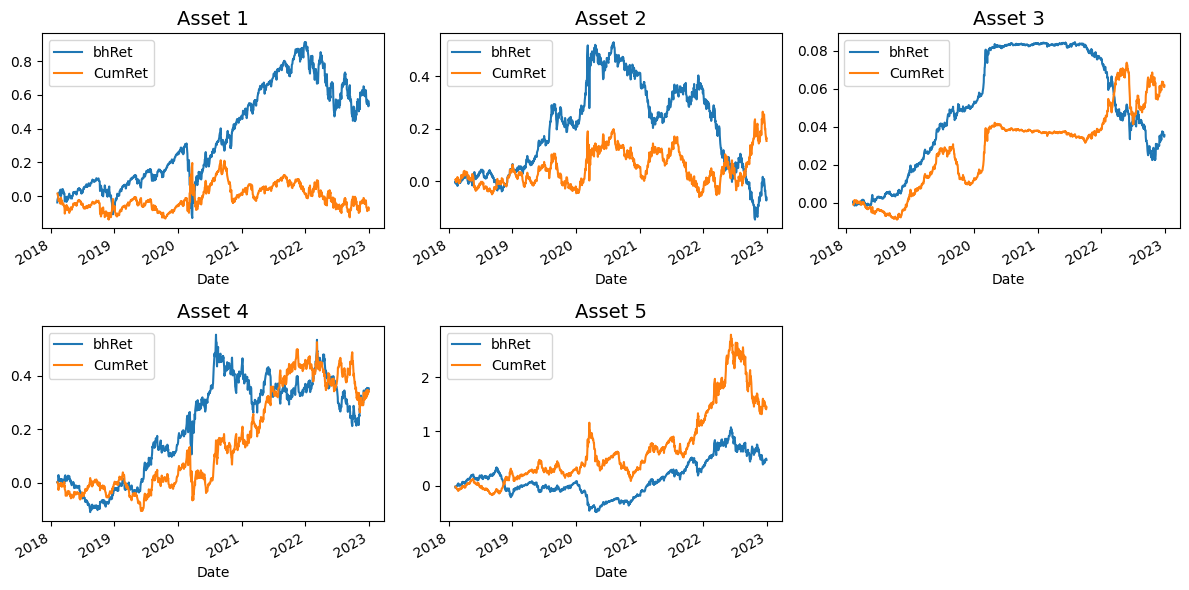

,Strategy Return,Buy and Hold Return
SPY,-8.30%,56.02%
TLT,15.35%,-6.23%
SHY,6.16%,3.56%
GLD,34.50%,35.31%
DBO,144.39%,47.53%


In [ ]:
price_predictions=[df_predictions_1["Pred LSTM"],
                   df_predictions_2["Pred LSTM"],
                   df_predictions_3["Pred LSTM"],
                   df_predictions_4["Pred LSTM"],
                   df_predictions_5["Pred LSTM"]]
price_actuals=[df_predictions_1["Actual"],
              df_predictions_2["Actual"],
              df_predictions_3["Actual"],
              df_predictions_4["Actual"],
              df_predictions_5["Actual"]]

fig, axes = plt.subplots(2, 3, figsize=(12, 6))
axes = axes.flatten()

FR=[]
BR=[]

for i in range(len(price_predictions)):
  df_predictions=pd.DataFrame()
  df_predictions["Positions"] = price_predictions[i].pct_change()[1:].apply(np.sign)
  df_predictions["Strat_ret"] = (
  df_predictions["Positions"].shift(1) * price_actuals[i].pct_change()[1:]
  )
  df_predictions["CumRet"] = (
    df_predictions["Strat_ret"].expanding().apply(lambda x: np.prod(1 + x) - 1)
  )
  df_predictions["bhRet"] = (
    price_actuals[i].pct_change()[1:].expanding().apply(lambda x: np.prod(1 + x) - 1)
  )
  df_predictions["Date"] = dates_y_test.flatten()[1:]

  Final_Return = np.prod(1 + df_predictions["Strat_ret"]) - 1
  Buy_Return = np.prod(1 + price_actuals[i].pct_change()[1:]) - 1
  FR.append(Final_Return)
  BR.append(Buy_Return)

  #print("Asset ", i+1, ": ")
  #print("Strat Return =", round(Final_Return,4) * 100, "%")
  #print("Buy and Hold Return =", round(Buy_Return, 4) * 100, "%")

  ax = axes[i]
  df_predictions.plot(x="Date", y="bhRet", ax=ax)
  df_predictions.plot(x="Date", y="CumRet", ax=ax)
  ax.set_title("Asset "+ str(i+1), fontsize = 14)

# Check if there are any unused axes left
if len(price_predictions) < len(axes):
  # Delete the last axes object
  fig.delaxes(axes[-1]) # Use axes[-1] to always delete the last axes object

plt.tight_layout()
plt.show()

df_strategies = pd.DataFrame({'Strategy Return': FR, 'Buy and Hold Return': BR}, index=tickers).style.format("{:.2%}")
df_strategies

In [ ]:
# Calculate the buy-and-hold return of an equally weighted portfolio
df_bh = pd.DataFrame({
    'Asset 1': df_predictions_1['Actual'],
    'Asset 2': df_predictions_2['Actual'],
    'Asset 3': df_predictions_3['Actual'],
    'Asset 4': df_predictions_4['Actual'],
    'Asset 5': df_predictions_5['Actual']
})

df_bh['Portfolio'] = df_bh.mean(axis=1)
# Use iloc to access the first and last element of the series using their position
portfolio_return = (df_bh['Portfolio'].iloc[-1] / df_bh['Portfolio'].iloc[0]) - 1

print(f"Equally Weighted Portfolio Buy-and-Hold Return: {round(portfolio_return * 100, 2)}%")

Equally Weighted Portfolio Buy-and-Hold Return: 32.63%


Calculations show that, for every asset except for SPY and GLD, the strategy chosen in step 2.d overperforms a buy-and-hold-strategy over the same period. For DBO, the chosen strategy is about 3 times as profitable as the buy-and-hold one and nearly 150%. For SPY, the chosen strategy forecasts a loss. For GLD, performances as moderately positive, and so on. The fluctuation patterns are similar in both strategies.

The buy-and-hold return of an equally weighted portfolio is calculated at 32.63%. Given the previous results, it seems that leaning towards DBO or at least GLD using the chosen strategy is more profitable than balancing investments across all asset classes.


## **Step 3 - Multi-output analysis**

### a. Building the Model

In [ ]:
# Build a multi-output LSTM model for the 5 assets defined above

def build_multi_output_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=100, return_sequences=True, input_shape=input_shape, kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.2, seed=1234))
    model.add(LSTM(units=50, return_sequences=False, kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.2, seed=1234))
    model.add(Dense(units=5))  # 5 output units for 5 assets

    model.compile(optimizer='adam', loss='mse')
    return model

# Combine the training data for all assets
X_train_combined = np.concatenate((X_train_seq_1, X_train_seq_2, X_train_seq_3, X_train_seq_4, X_train_seq_5), axis=0)
y_train_combined = np.concatenate((y_train_seq_1, y_train_seq_2, y_train_seq_3, y_train_seq_4, y_train_seq_5), axis=0)

# Reshape y_train_combined to have shape (num_samples, num_outputs)
y_train_combined = y_train_combined.reshape(-1, 1)

# Build the multi-output model
multi_output_model = build_multi_output_model(input_shape)


In [ ]:
multi_output_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                       │ (None, 25, 100)             │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 25, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_11 (LSTM)                       │ (None, 50)                  │          30,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 5)                   │             255 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 213,767 (835.03 KB)

 Trainable params: 71,255 (278.34 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 142,512 (556.69 KB)

### b. Training and testing the Model

In [ ]:
# Train the model - this uses the train_model function defined in the previous test
multi_output_history = train_model(multi_output_model, X_train_combined, y_train_combined)

iteration complete


351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Asset 1: In-sample R-squared 0.991 and MSE 14.2716
Asset 2: In-sample R-squared 0.5754 and MSE 111.8506
Asset 3: In-sample R-squared -0.6074 and MSE 6.6307
Asset 4: In-sample R-squared -1.5006 and MSE 1548.7858
Asset 5: In-sample R-squared -4.4394 and MSE 378.5081



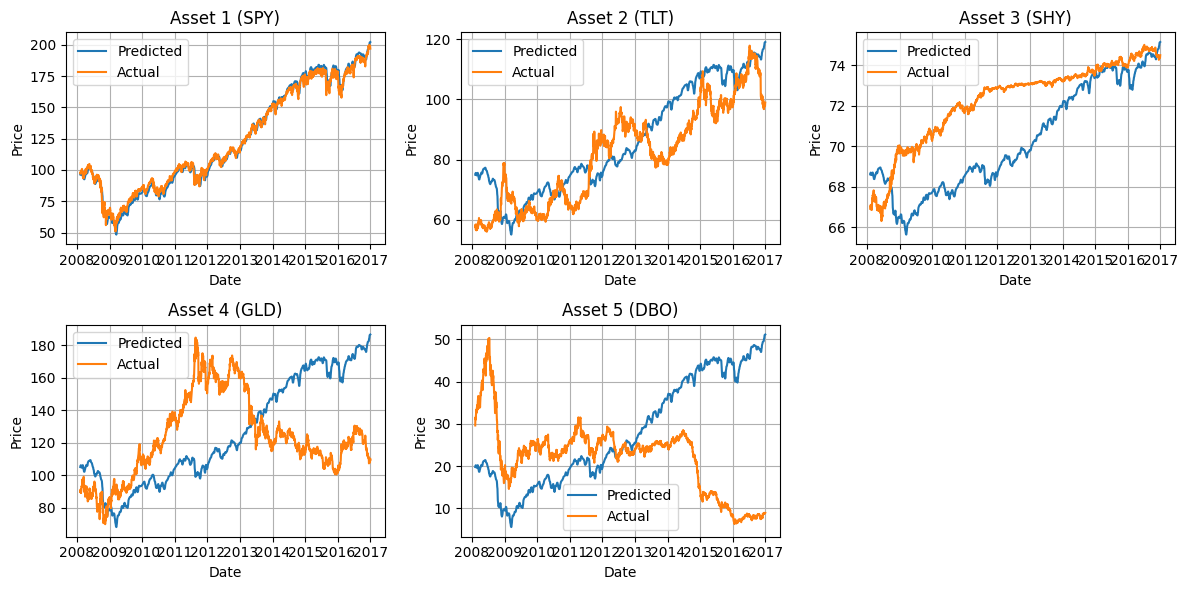

In [ ]:
# Generate predictions for the training set
train_predictions = multi_output_model.predict(X_train_combined)

# Reshape predictions to (num_samples, num_assets)
train_predictions = train_predictions.reshape(-1, 5)

# Inverse transform predictions and actual values for each asset
predicted_prices = []
actual_prices = []
for i in range(5):
    scaler = scalers_list[i]
    predicted_prices.append(scaler.inverse_transform(train_predictions[:, i].reshape(-1, 1)).flatten())
    actual_prices.append(scaler.inverse_transform(y_train_combined[i * len(y_train_seq_1):(i + 1) * len(y_train_seq_1)].reshape(-1, 1)).flatten())

# Calculate R-squared for each asset
for i in range(5):
    mse = mean_squared_error(actual_prices[i], predicted_prices[i][:len(dates_y_train)]).round(4)
    r2 = r2_score(actual_prices[i], predicted_prices[i][:len(dates_y_train)]).round(4)
    print(f"Asset {i+1}: In-sample R-squared {r2} and MSE {mse}")

print("")

# Create a figure and subplots
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
axes = axes.flatten()

# Plot predictions vs actual values for each asset
for i in range(5):
    ax = axes[i]
    # Slice the predicted prices for each asset to match the length of dates_y_train
    ax.plot(dates_y_train.flatten(), predicted_prices[i][:len(dates_y_train)], label='Predicted')
    ax.plot(dates_y_train.flatten(), actual_prices[i], label='Actual')
    ax.set_title(f'Asset {i+1} ({tickers[i]})')
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    ax.legend()
    ax.grid(True)

# Remove the unused subplot
fig.delaxes(axes[5])

plt.tight_layout()
plt.show()

In-sample performance for SPY is exceptionally high, with R-squared close to 100% and a very low MSE in comparison with its values. A potential explanation for this is that SPY represents a variety of industries, so it prevails. Predictions for TLT come with a moderate R-squared. In all other cases, important discrepancies are observed between actual and predicted values, with the former being greater than the latter before 2012 to 2013. Conversion from prices to returns is expected to introduce distortions. Actual vs predicted returns are shown below; however, it seems that the multi-output model does a better job than individual models in capturing the magnitude of the series (at least for the training data).

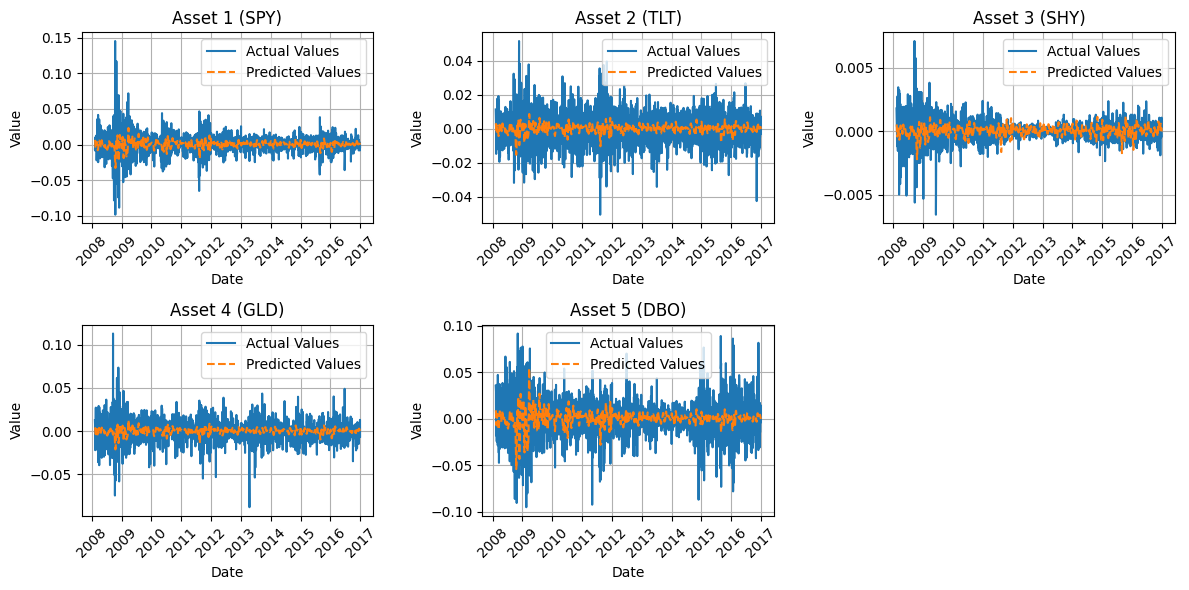

Asset 1: RMSE 0.0142
Asset 2: RMSE 0.0101
Asset 3: RMSE 0.0009
Asset 4: RMSE 0.013
Asset 5: RMSE 0.0218


In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6)) # Create a figure with a 2x3 grid of subplots
axs = axs.flatten() # Flatten the array of axes for easier iteration

# Plot for each asset
for i in range(5):
    plot_predictions_vs_actual(dates_y_train.flatten()[1:],
                               pd.Series(actual_prices[i]).pct_change()[1:],
                               pd.Series(predicted_prices[i][:len(dates_y_train)]).pct_change()[1:], i+1, axs[i])

fig.delaxes(axs[5]) # Turn off the empty subplot (6th subplot)
plt.tight_layout() # Adjust layout
plt.show()

# Calculate for each asset
for i in range(5):
    y_true = pd.Series(actual_prices[i]).pct_change()[1:]
    y_pred = pd.Series(predicted_prices[i][:len(dates_y_train)]).pct_change()[1:]
    rmse = np.sqrt(mean_squared_error(y_true, y_pred)).round(4)
    print(f"Asset {i+1}: RMSE {rmse}")

In [ ]:
a = multi_output_model.evaluate(X_train_combined, y_train_combined)
print("Model MSE, train data: ", round(a,4))

351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0045
Model MSE, train data:  0.0048


Now, on to testing:

193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Asset 1: Out-of-sample R-squared 0.6426 and MSE 1727.8211
Asset 2: Out-of-sample R-squared -5.0998 and MSE 1817.681
Asset 3: Out-of-sample R-squared -1.3864 and MSE 11.8558
Asset 4: Out-of-sample R-squared -22.5917 and MSE 11884.1813
Asset 5: Out-of-sample R-squared -459.4204 and MSE 4772.6414



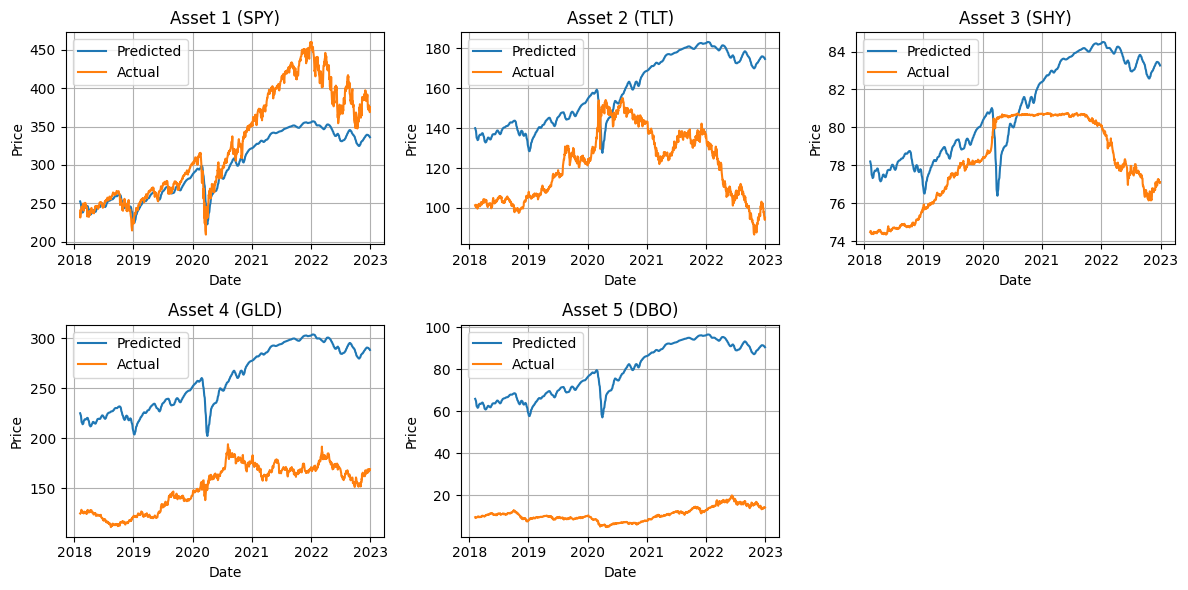

In [ ]:
# Combine the test data for all assets
X_test_combined = np.concatenate((X_test_seq_1, X_test_seq_2, X_test_seq_3, X_test_seq_4, X_test_seq_5), axis=0)
y_test_combined = np.concatenate((y_test_seq_1, y_test_seq_2, y_test_seq_3, y_test_seq_4, y_test_seq_5), axis=0)

# Reshape y_test_combined to have shape (num_samples, num_outputs)
y_test_combined = y_test_combined.reshape(-1, 1)

# Generate predictions for the training set
test_predictions = multi_output_model.predict(X_test_combined)

# Reshape predictions to (num_samples, num_assets)
test_predictions = test_predictions.reshape(-1, 5)

# Inverse transform predictions and actual values for each asset
predicted_prices = []
actual_prices = []
for i in range(5):
    scaler = scalers_list[i]
    predicted_prices.append(scaler.inverse_transform(test_predictions[:, i].reshape(-1, 1)).flatten())
    actual_prices.append(scaler.inverse_transform(y_test_combined[i * len(y_test_seq_1):(i + 1) * len(y_test_seq_1)].reshape(-1, 1)).flatten())

# Calculate R-squared for each asset
for i in range(5):
    mse = mean_squared_error(actual_prices[i], predicted_prices[i][:len(dates_y_test)]).round(4)
    r2 = r2_score(actual_prices[i], predicted_prices[i][:len(dates_y_test)]).round(4)
    print(f"Asset {i+1}: Out-of-sample R-squared {r2} and MSE {mse}")

print("")

# Create a figure and subplots
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
axes = axes.flatten()

# Plot predictions vs actual values for each asset
for i in range(5):
    ax = axes[i]
    # Slice the predicted prices for each asset to match the length of dates_y_train
    ax.plot(dates_y_test.flatten(), predicted_prices[i][:len(dates_y_test)], label='Predicted')
    ax.plot(dates_y_test.flatten(), actual_prices[i], label='Actual')
    ax.set_title(f'Asset {i+1} ({tickers[i]})')
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    ax.legend()
    ax.grid(True)

# Remove the unused subplot
fig.delaxes(axes[5])

plt.tight_layout()
plt.show()

Using the testing data, results are worse but not unreasonable. SPY is better predicted than all the other assets, with an R-squared close to 65% and the smallest MSE in comparison; actuals are generally underpredicted, with the gap becoming larger after 2020. It seems that all series undergo some change around 2020, which is detected by the model with a slight lag. Prices for all assets except for SPY are overpredicted, with notable gaps for DBO and GLD, as if the market (SPY)  wanted to pull them to an increasing direction.

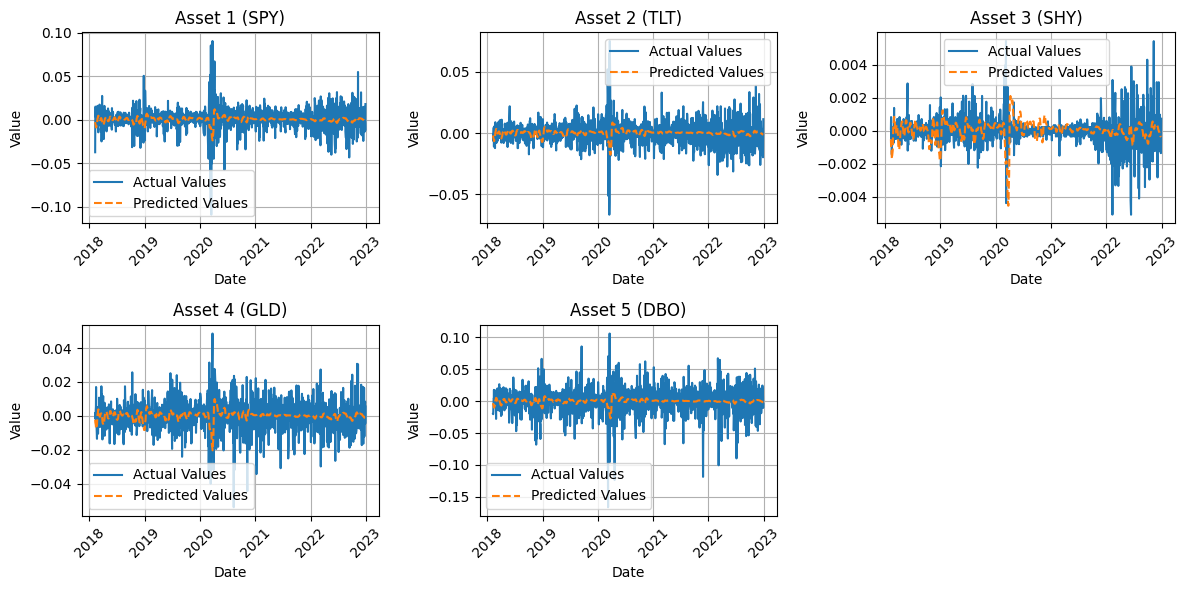

Asset 1: RMSE 0.0139
Asset 2: RMSE 0.0106
Asset 3: RMSE 0.0011
Asset 4: RMSE 0.0095
Asset 5: RMSE 0.022


In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6)) # Create a figure with a 2x3 grid of subplots
axs = axs.flatten() # Flatten the array of axes for easier iteration

# Plot for each asset
for i in range(5):
    plot_predictions_vs_actual(dates_y_test.flatten()[1:],
                               pd.Series(actual_prices[i]).pct_change()[1:],
                               pd.Series(predicted_prices[i][:len(dates_y_test)]).pct_change()[1:], i+1, axs[i])

fig.delaxes(axs[5]) # Turn off the empty subplot (6th subplot)
plt.tight_layout() # Adjust layout
plt.show()

# Calculate for each asset
for i in range(5):
    y_true = pd.Series(actual_prices[i]).pct_change()[1:]
    y_pred = pd.Series(predicted_prices[i][:len(dates_y_test)]).pct_change()[1:]
    rmse = np.sqrt(mean_squared_error(y_true, y_pred)).round(4)
    print(f"Asset {i+1}: RMSE {rmse}")

In [ ]:
b = multi_output_model.evaluate(X_test_combined, y_test_combined)
print("Model MSE, test data: ", round(b,4))

193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1272
Model MSE, test data:  0.0708


### c. Definition of Strategy

As in Step 2.d, we will trade long (buy) all assets whenever the 25-day return predictions are positive and short (sell) assets when negative.

### d. Backtesting

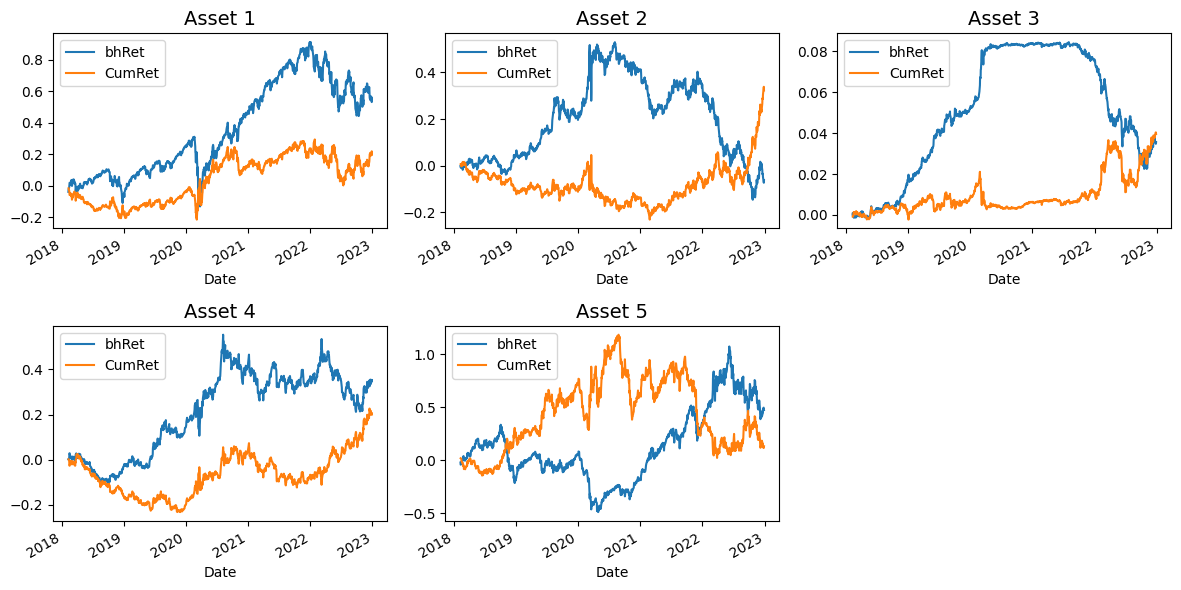

,Strategy Return,Buy and Hold Return
SPY,19.81%,56.02%
TLT,32.30%,-6.23%
SHY,3.96%,3.56%
GLD,20.03%,35.31%
DBO,13.38%,47.53%


In [ ]:
price_predictions=[predicted_prices[0][:len(dates_y_test)],
                   predicted_prices[1][:len(dates_y_test)],
                   predicted_prices[2][:len(dates_y_test)],
                   predicted_prices[3][:len(dates_y_test)],
                   predicted_prices[4][:len(dates_y_test)]]
price_actuals=[actual_prices[0],
              actual_prices[1],
              actual_prices[2],
              actual_prices[3],
              actual_prices[4]]

fig, axes = plt.subplots(2, 3, figsize=(12, 6))
axes = axes.flatten()

FR=[]
BR=[]

for i in range(len(price_predictions)):
  df_predictions=pd.DataFrame()
  df_predictions["Positions"] = pd.Series(price_predictions[i]).pct_change()[1:].apply(np.sign)
  df_predictions["Strat_ret"] = (
  df_predictions["Positions"].shift(1) * pd.Series(price_actuals[i]).pct_change()[1:]
  )
  df_predictions["CumRet"] = (
    df_predictions["Strat_ret"].expanding().apply(lambda x: np.prod(1 + x) - 1)
  )
  df_predictions["bhRet"] = (
    pd.Series(price_actuals[i]).pct_change()[1:].expanding().apply(lambda x: np.prod(1 + x) - 1)
  )
  df_predictions["Date"] = dates_y_test.flatten()[1:]

  Final_Return = np.prod(1 + df_predictions["Strat_ret"]) - 1
  Buy_Return = np.prod(1 + pd.Series(price_actuals[i]).pct_change()[1:]) - 1
  FR.append(Final_Return)
  BR.append(Buy_Return)

  #print("Asset ", i+1, ": ")
  #print("Strat Return =", round(Final_Return,4) * 100, "%")
  #print("Buy and Hold Return =", round(Buy_Return, 4) * 100, "%")

  ax = axes[i]
  df_predictions.plot(x="Date", y="bhRet", ax=ax)
  df_predictions.plot(x="Date", y="CumRet", ax=ax)
  ax.set_title("Asset "+ str(i+1), fontsize = 14)

# Check if there are any unused axes left
if len(price_predictions) < len(axes):
  # Delete the last axes object
  fig.delaxes(axes[-1]) # Use axes[-1] to always delete the last axes object

plt.tight_layout()
plt.show()

df_strategies = pd.DataFrame({'Strategy Return': FR, 'Buy and Hold Return': BR}, index=tickers).style.format("{:.2%}")
df_strategies

New calculations show that, at the end of the test period, buy-and-hold strategies are superior to the previously defined trading strategy for all assets except TLT and SHY. However, for the greatest part of the period, the buy-and-hold strategy is superior for all assets except DBO. The chosen trading strategy for TLT yields a final return 5 times the absolute size of the (negative) buy-and-hold return. Given these results, it seems one should avoid SPY, DBO and GLD in favor of TLT and SHY, but the investment will not be more profitable than an equally-weighted portfolio.

## **Step 4 - Discussion**

Single-output architectures are optimized for stand-alone prediction targets and may exhibit high accuracy for ‘ceteris paribus’ tasks, i.e. tasks where we wish to focus on the intrinsic properties of time series irrespective of the market. However, they may fail to capture complex market dynamics, with actual correlations between asset returns going sufficiently back in time. Multi-output architectures, on the other hand, leverage asset interactions to inform predictions.

In terms of backtesting, single-output models may perform very well on past unseen data, to the point of overfitting. Nevertheless, given they only predict one target, they may perform poorly in live trading as they do not take into account information and they do not produce insights on other relevant (correlated) financial indicators. This is one of the limitations multi-output architectures intend to overcome.

It can be argued that multi-output architectures gather broader information (i.e. different financial metrics) and can be more generic and robust in dynamic environments with interacting factors. In contrast, single-output architectures can be seen as self-reliant, which enhances interpretability but magnifies both good and bad prediction results.

# **3. Key Learnings and Recommendations:**

Both single-output and multi-output network architectures are useful in modeling financial data. Here are a few considerations to implement them effectively:

1. It is important to understand the nature of the prediction task at hand. Single-output models fit clear, singular targets (e.g. estimation of a default probability), where multiple-output models fit combined targets (e.g. evaluation of portfolio performance).
2. The quality of available data affects the choice of architecture. When data is scarce or noisy, a single-output model may be better as it requires less data to train and can focus on a single objective. Large, high-quality datasets can help extract information on interaction dynamics through multi-output models.
3. Feature engineering might be more complex in multi-output models, as it is often necessary to create composite indicators or draw from domain-specific experience in order to capture interdependencies.
4. Overfitting is a real concern in any case, so hyperparameter optimization and regularization need to be applied appropriately. Ensemble learning may help with underfitting.

# **References:**

Chollet, François. Deep Learning with Python. New York,
Manning Publications Co, 2018.

Zhang, Aston, et al. Dive into Deep Learning. https://d2l.ai/d2l-en.pdf